# U-NET 향상시키기

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


In [2]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# Split dataset
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))


Number of training examples: 240
Number of test examples: 60


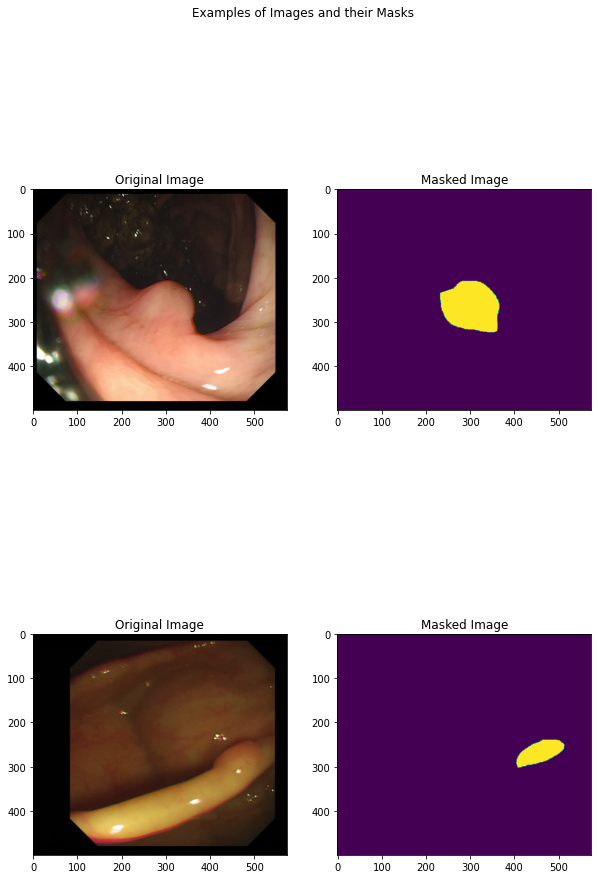

In [3]:

display_num = 2
r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()


In [4]:

# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4
max_epochs = 10


In [5]:

def _process_pathnames(fname, label_path):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img, [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img, [width_shift_range, height_shift_range])
    return output_img, label_img

def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img


In [6]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU available.")

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
!pip install pynvml


     |████████████████████████████████| 40 kB 3.5 MB/s            


In [8]:
import pynvml

pynvml.nvmlInit()
deviceCount = pynvml.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"Device {i}: {pynvml.nvmlDeviceGetName(handle)}")
    print(f"  Total memory: {mem_info.total / (1024**2)} MB")
    print(f"  Used memory : {mem_info.used / (1024**2)} MB")
    print(f"  Free memory : {mem_info.free / (1024**2)} MB\n")

pynvml.nvmlShutdown()


Device 0: Tesla T4
  Total memory: 15360.0 MB
  Used memory : 434.4375 MB
  Free memory : 14925.5625 MB



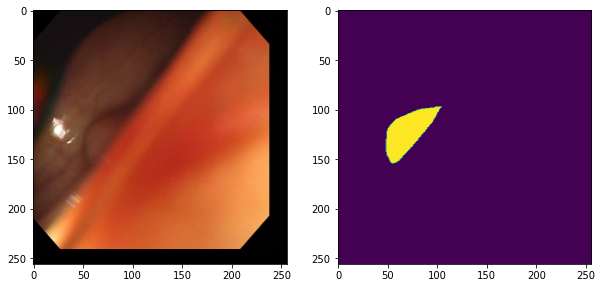

In [9]:

def _augment(img,
             label_img,
             resize=None,
             scale=1,
             hue_delta=0.,
             horizontal_flip=True,
             width_shift_range=0.05,
             height_shift_range=0.05):
    if resize is not None:
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()



In [10]:
# 여기서부터 U-Net 모델 정의

class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)
        return x

class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)
        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)
        return decoder

class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)
        return encoder_pool, encoder

class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)
        return decoder



In [11]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)
        return outputs

# baseline U-Net model
unet_model = UNet()



In [12]:
# 개선된 U-Net 모델 (예: dropout 추가, optimizer 변경 등)

class UNetImproved(tf.keras.Model):
    def __init__(self, dropout_rate=0.1):
        super(UNetImproved, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)
        self.dropout = layers.Dropout(dropout_rate)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs, training=training)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool, training=training)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool, training=training)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool, training=training)

        center = self.center(encoder4_pool, training=training)
        center = self.dropout(center, training=training)  # dropout 추가

        decoder4 = self.decoder_block4(center, encoder4, training=training)
        decoder3 = self.decoder_block3(decoder4, encoder3, training=training)
        decoder2 = self.decoder_block2(decoder3, encoder2, training=training)
        decoder1 = self.decoder_block1(decoder2, encoder1, training=training)

        outputs = self.output_conv(decoder1)
        return outputs

unet_model_improved = UNetImproved(dropout_rate=0.2)

In [13]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + dice_loss(y_true, y_pred)
    return loss


In [14]:

# baseline U-Net 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
unet_model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])


In [15]:

# 개선된 U-Net 모델: 예를 들어 learning rate를 더 작게 한다거나, 다른 optimizer를 사용하는 등의 변경
improved_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
unet_model_improved.compile(optimizer=improved_optimizer, loss=bce_dice_loss, metrics=[dice_loss])


In [16]:

checkpoint_dir_unet =os.path.join(DATASET_PATH,'train_ckpt/unet_model')
if not os.path.isdir(checkpoint_dir_unet):
    os.makedirs(checkpoint_dir_unet)

cp_callback_unet = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_unet,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

checkpoint_dir_unet_improved =os.path.join(DATASET_PATH,'train_ckpt/unet_improved_model')
if not os.path.isdir(checkpoint_dir_unet_improved):
    os.makedirs(checkpoint_dir_unet_improved)

cp_callback_unet_improved = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_unet_improved,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)



In [17]:
# 학습
history_unet = unet_model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_unet]
                    )


Epoch 1/10
60/60 [==============================] - 76s 430ms/step - loss: 0.9919 - dice_loss: 0.7281 - val_loss: 4.4423 - val_dice_loss: 0.9997
Epoch 2/10
60/60 [==============================] - 27s 428ms/step - loss: 0.9202 - dice_loss: 0.7084 - val_loss: 39.2676 - val_dice_loss: 1.0000
Epoch 3/10
60/60 [==============================] - 27s 435ms/step - loss: 0.9014 - dice_loss: 0.7005 - val_loss: 1.1464 - val_dice_loss: 0.8556
Epoch 4/10
60/60 [==============================] - 28s 440ms/step - loss: 0.9058 - dice_loss: 0.7059 - val_loss: 24.6887 - val_dice_loss: 1.0000
Epoch 5/10
60/60 [==============================] - 28s 448ms/step - loss: 0.8839 - dice_loss: 0.6859 - val_loss: 1.5941 - val_dice_loss: 0.9419
Epoch 6/10
60/60 [==============================] - 28s 454ms/step - loss: 0.8853 - dice_loss: 0.6892 - val_loss: 1.0126 - val_dice_loss: 0.8271
Epoch 7/10
60/60 [==============================] - 28s 452ms/step - loss: 0.8643 - dice_loss: 0.6725 - val_loss: 1.0276 - val_d

In [18]:

history_unet_improved = unet_model_improved.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_unet_improved]
                    )



Epoch 1/10
60/60 [==============================] - 32s 464ms/step - loss: 1.1352 - dice_loss: 0.7391 - val_loss: 1.3823 - val_dice_loss: 0.8007
Epoch 2/10
60/60 [==============================] - 29s 455ms/step - loss: 0.8488 - dice_loss: 0.6117 - val_loss: 1.1363 - val_dice_loss: 0.7776
Epoch 3/10
60/60 [==============================] - 29s 458ms/step - loss: 0.7252 - dice_loss: 0.5184 - val_loss: 1.0243 - val_dice_loss: 0.7304
Epoch 4/10
60/60 [==============================] - 29s 458ms/step - loss: 0.6154 - dice_loss: 0.4410 - val_loss: 1.1287 - val_dice_loss: 0.7844
Epoch 5/10
60/60 [==============================] - 29s 456ms/step - loss: 0.5424 - dice_loss: 0.3875 - val_loss: 1.0585 - val_dice_loss: 0.8348
Epoch 6/10
60/60 [==============================] - 28s 454ms/step - loss: 0.5063 - dice_loss: 0.3608 - val_loss: 0.8961 - val_dice_loss: 0.6760
Epoch 7/10
60/60 [==============================] - 29s 456ms/step - loss: 0.4634 - dice_loss: 0.3295 - val_loss: 0.9661 - val_dic

In [19]:

# mean IoU 함수
def mean_iou(y_true, y_pred, num_classes=2):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)


In [20]:

# mean IoU 계산
mean_unet = []
mean_unet_improved = []

for images, labels in test_dataset:
    predictions_unet = unet_model(images, training=False)
    m_unet = mean_iou(labels, predictions_unet)
    mean_unet.append(m_unet)
    
    predictions_unet_improved = unet_model_improved(images, training=False)
    m_unet_improved = mean_iou(labels, predictions_unet_improved)
    mean_unet_improved.append(m_unet_improved)

mean_unet = np.mean(mean_unet)
mean_unet_improved = np.mean(mean_unet_improved)

print("Baseline U-Net mean_iou: {}".format(mean_unet))
print("Improved U-Net mean_iou: {}".format(mean_unet_improved))



Baseline U-Net mean_iou: 0.11160794076855653
Improved U-Net mean_iou: 0.7516997350276662


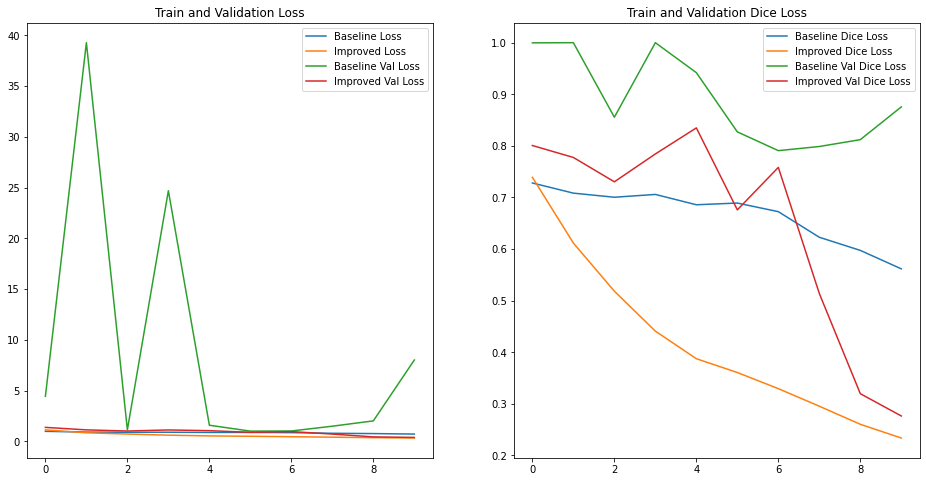

In [21]:
# 학습 곡선 비교 시각화
def plot_training_history(history, history_improved):
    epochs_range = range(max_epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Baseline Loss')
    plt.plot(epochs_range, history_improved.history['loss'], label='Improved Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Baseline Val Loss')
    plt.plot(epochs_range, history_improved.history['val_loss'], label='Improved Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['dice_loss'], label='Baseline Dice Loss')
    plt.plot(epochs_range, history_improved.history['dice_loss'], label='Improved Dice Loss')
    plt.plot(epochs_range, history.history['val_dice_loss'], label='Baseline Val Dice Loss')
    plt.plot(epochs_range, history_improved.history['val_dice_loss'], label='Improved Val Dice Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Validation Dice Loss')
    plt.show()

plot_training_history(history_unet, history_unet_improved)


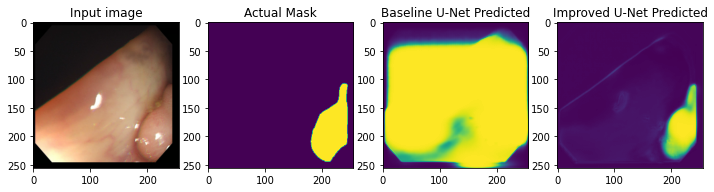

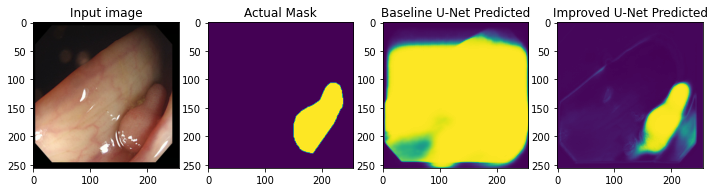

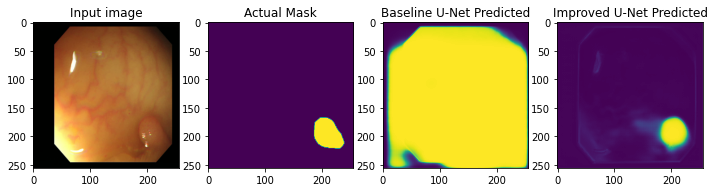

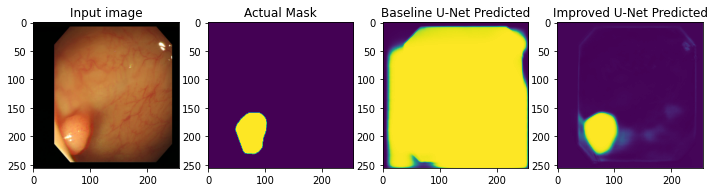

In [22]:
# 시각적으로 비교
def print_images(model_baseline, model_improved):
    for test_images, test_labels in test_dataset.take(1):
        predictions_unet = model_baseline(test_images, training=False)
        predictions_unet_improved = model_improved(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(12, 20))
            plt.subplot(1, 4, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 4, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 4, 3)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("Baseline U-Net Predicted")
            
            plt.subplot(1, 4, 4)
            plt.imshow(predictions_unet_improved[i, :, :, 0])
            plt.title("Improved U-Net Predicted")
            plt.show()

print_images(unet_model, unet_model_improved)
